# Demographics in Florida Course Enrollment, by District
## Source Data
Course enrolment data, by district, with student demographics for the 1718 school year were obtained through a data request from [Florida Department of Education](http://www.FLDOE.org). Median household income, by Florida county (i.e., district), came from the [Florida Dept of Health](http://www.flhealthcharts.com/charts/OtherIndicators/NonVitalIndRateOnlyDataViewer.aspx?cid=0293). The remainder of district-level data are publicly available from the [FLDOE Student Data site](http://www.fldoe.org/accountability/data-sys/edu-info-accountability-services/pk-12-public-school-data-pubs-reports/students.stml).

*see [adamlamee.com](http://www.adamlamee.com) for more details*

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib as mpl
from matplotlib import colors
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
mpl.rcParams['font.sans-serif'] = "AppleGothic"
pd.set_option('display.max_rows', 80)
pd.set_option('display.max_columns', 60)

biology = ["2000310","2000315","2000320","2000321","2000322","2000323","2000330","2000335","2000340","2000800","2000805","2000810","2000820"]
chemistry = ["2003340","2003345","2003350","2003360","2003370","2003371","2003372","2003373","2003800","2003805","2003810","2003820"]
physics = ["2003380","2003385","2003390","2003410","2003421","2003422","2003425","2003430","2003431","2003432","2003433","2003836","2003840","2003845","2003850"]
bio_color = '#55AD89'
chem_color = '#6388B4'
phy_color = '#FFAE34'
colors_area = {"biology": '#55AD89', "chemistry": '#6388B4', "physics": '#FFAE34'}

In [2]:
# grab district data
district_data = pd.DataFrame()
district_data = pd.read_csv('../data/19_dist_info.csv').fillna(0)
district_data.head(3)

,district_number,district_name,1718s2_seniors,1718s2_students,2017_Median_income,1718s2_white_enrollment,1718s2_black_enrollment,1718s2_hispanic_enrollment,1819s2_FRL,1718s5_daily_attendance,1617s5_abs21days,1718_stability,1718_fed_grad_rate,1718_frl_grad_rate,1718_F_grad_rate,1718_M_grad_rate,1718_W_grad_rate,1718_B_grad_rate,1718_H_grad_rate
0,1,ALACHUA,2119,29764,45478,0.43,0.35,0.10,0.64,0.937,0.06,0.969,0.880,0.818,0.906,0.852,0.922,0.792,0.837
1,2,BAKER,335,5044,59506,0.82,0.12,0.02,0.70,0.928,0.15,0.995,0.755,0.636,0.805,0.705,0.749,0.787,0.000
2,3,BAY,1748,28076,50283,0.68,0.15,0.08,0.59,0.913,0.13,0.965,0.811,0.736,0.848,0.775,0.830,0.710,0.807


In [3]:
dist_list = district_data.district_name.unique()
dist_list

array(['ALACHUA', 'BAKER', 'BAY', 'BRADFORD', 'BREVARD', 'BROWARD',
       'CALHOUN', 'CHARLOTTE', 'CITRUS', 'CLAY', 'COLLIER', 'COLUMBIA',
       'MIAMI-DADE', 'DESOTO', 'DIXIE', 'DUVAL', 'ESCAMBIA', 'FLAGLER',
       'FRANKLIN', 'GADSDEN', 'GILCHRIST', 'GLADES', 'GULF', 'HAMILTON',
       'HARDEE', 'HENDRY', 'HERNANDO', 'HIGHLANDS', 'HILLSBOROUGH',
       'HOLMES', 'INDIAN RIVER', 'JACKSON', 'JEFFERSON', 'LAFAYETTE',
       'LAKE', 'LEE', 'LEON', 'LEVY', 'LIBERTY', 'MADISON', 'MANATEE',
       'MARION', 'MARTIN', 'MONROE', 'NASSAU', 'OKALOOSA', 'OKEECHOBEE',
       'ORANGE', 'OSCEOLA', 'PALM BEACH', 'PASCO', 'PINELLAS', 'POLK',
       'PUTNAM', 'ST. JOHNS', 'ST. LUCIE', 'SANTA ROSA', 'SARASOTA',
       'SEMINOLE', 'SUMTER', 'SUWANNEE', 'TAYLOR', 'UNION', 'VOLUSIA',
       'WAKULLA', 'WALTON', 'WASHINGTON', 'DEAF/BLIND', 'FL VIRTUAL',
       'FAU LAB SCH', 'FSU LAB SCH', 'FAMU LAB SCH', 'UF LAB SCH',
       'FLORIDA'], dtype=object)

In [4]:
# grab course enrollment data from 1718 PERA request
# these are totals for each district, by course
# data were first cleaned and fractional enrollement determined, wherever possible
course_data = pd.DataFrame()
course_data = pd.read_csv('../data/1718s3-demog.csv').fillna(0)

#format enrollment to integers
cols = course_data.iloc[:,4:22].columns
course_data[cols] = course_data[cols].astype(np.int64)
course_data.head(3)

,district_number,district_name,course_number,course_name,W_F,W_M,B_F,B_M,HL_F,HL_M,A_F,A_M,NH_F,NH_M,AI_F,AI_M,MR_F,MR_M,Total_F,Total_M,Total_enrolled,Total_NW,frac_girls,frac_nonwhite
0,1,ALACHUA,1200310,ALG 1,238,274,283,270,78,85,0,17,0,0,0,0,28,42,637,689,1326,814,0.480392,0.613876
1,1,ALACHUA,1200320,ALG 1 HON,256,295,70,45,38,37,49,48,0,0,0,0,30,27,443,454,897,346,0.493868,0.385730
2,1,ALACHUA,1200330,ALG 2,114,124,83,64,25,34,0,0,0,0,0,0,13,20,242,248,490,252,0.493878,0.514286


In [5]:
#combines district_data + course_data --> all_data
all_data = pd.DataFrame()
all_data = district_data.copy()

# Physics takers
phy_takers_temp = pd.DataFrame()
phy_takers_temp = course_data.loc[(course_data['course_number'].isin(physics))].groupby("district_name")
phy_takers = pd.DataFrame()
phy_takers['district_name'] = phy_takers_temp.Total_F.sum().index
phy_takers['physics_girls'] = phy_takers_temp.Total_F.sum().values
phy_takers['physics_NW'] = phy_takers_temp.Total_NW.sum().values
phy_takers['physics_total'] = phy_takers_temp.Total_enrolled.sum().values
all_data = all_data.merge(phy_takers,on='district_name',how='left')
# Chemistry takers
chem_takers_temp = pd.DataFrame()
chem_takers_temp = course_data.loc[(course_data['course_number'].isin(chemistry))].groupby("district_name")
chem_takers = pd.DataFrame()
chem_takers['district_name'] = chem_takers_temp.Total_F.sum().index
chem_takers['chemistry_girls'] = chem_takers_temp.Total_F.sum().values
chem_takers['chemistry_NW'] = chem_takers_temp.Total_NW.sum().values
chem_takers['chemistry_total'] = chem_takers_temp.Total_enrolled.sum().values
all_data = all_data.merge(chem_takers,on='district_name',how='left')
# Biology takers
bio_takers_temp = pd.DataFrame()
bio_takers_temp = course_data.loc[(course_data['course_number'].isin(biology))].groupby("district_name")
bio_takers = pd.DataFrame()
bio_takers['district_name'] = bio_takers_temp.Total_F.sum().index
bio_takers['biology_girls'] = bio_takers_temp.Total_F.sum().values
bio_takers['biology_NW'] = bio_takers_temp.Total_NW.sum().values
bio_takers['biology_total'] = bio_takers_temp.Total_enrolled.sum().values
all_data = all_data.merge(bio_takers,on='district_name',how='left')
# unknown takers due to * in source data from < 10 in a category
unk_takers1 = pd.DataFrame()
unk_F_bio = course_data.loc[(course_data['course_number'].isin(biology)) & (course_data['Total_F'] == 0)].groupby("district_name")
unk_takers1['district_name'] = unk_F_bio.Total_F.sum().index
unk_takers1['unk_F_bio'] = unk_F_bio.Total_enrolled.sum().values
all_data = all_data.merge(unk_takers1,on='district_name',how='left')
unk_takers2 = pd.DataFrame()
unk_F_chem = course_data.loc[(course_data['course_number'].isin(chemistry)) & (course_data['Total_F'] == 0)].groupby("district_name")
unk_takers2['district_name'] = unk_F_chem.Total_F.sum().index
unk_takers2['unk_F_chem'] = unk_F_chem.Total_enrolled.sum().values
all_data = all_data.merge(unk_takers2,on='district_name',how='left')
unk_takers3 = pd.DataFrame()
unk_F_phy = course_data.loc[(course_data['course_number'].isin(physics)) & (course_data['Total_F'] == 0)].groupby("district_name")
unk_takers3['district_name'] = unk_F_phy.Total_F.sum().index
unk_takers3['unk_F_phy'] = unk_F_phy.Total_enrolled.sum().values
all_data = all_data.merge(unk_takers3,on='district_name',how='left')
unk_takers11 = pd.DataFrame()
unk_NW_bio = course_data.loc[(course_data['course_number'].isin(biology)) & (course_data['Total_NW'] == 0)].groupby("district_name")
unk_takers11['district_name'] = unk_NW_bio.Total_NW.sum().index
unk_takers11['unk_NW_bio'] = unk_NW_bio.Total_enrolled.sum().values
all_data = all_data.merge(unk_takers11,on='district_name',how='left')
unk_takers22 = pd.DataFrame()
unk_NW_chem = course_data.loc[(course_data['course_number'].isin(chemistry)) & (course_data['Total_NW'] == 0)].groupby("district_name")
unk_takers22['district_name'] = unk_NW_chem.Total_NW.sum().index
unk_takers22['unk_NW_chem'] = unk_NW_chem.Total_enrolled.sum().values
all_data = all_data.merge(unk_takers22,on='district_name',how='left')
unk_takers33 = pd.DataFrame()
unk_NW_phy = course_data.loc[(course_data['course_number'].isin(physics)) & (course_data['Total_NW'] == 0)].groupby("district_name")
unk_takers33['district_name'] = unk_NW_phy.Total_NW.sum().index
unk_takers33['unk_NW_phy'] = unk_NW_phy.Total_enrolled.sum().values
all_data = all_data.merge(unk_takers33,on='district_name',how='left')
# fractional enrollment
all_data = all_data.fillna(0)
all_data['bio_girls_frac'] = all_data['biology_girls'] / all_data['biology_total']
all_data['bio_girls_unc'] = all_data['unk_F_bio']/all_data['biology_total']
all_data['bio_NW_frac'] = all_data['biology_NW'] / all_data['biology_total']
all_data['bio_NW_unc'] = all_data['unk_NW_bio']/all_data['biology_total']
all_data['chem_girls_frac'] = all_data['chemistry_girls'] / all_data['chemistry_total']
all_data['chem_girls_unc'] = all_data['unk_F_chem']/all_data['chemistry_total']
all_data['chem_NW_frac'] = all_data['chemistry_NW'] / all_data['chemistry_total']
all_data['chem_NW_unc'] = all_data['unk_NW_chem']/all_data['chemistry_total']
all_data['phy_girls_frac'] = all_data['physics_girls'] / all_data['physics_total']
all_data['phy_girls_unc'] = all_data['unk_F_phy']/all_data['physics_total']
all_data['phy_NW_frac'] = all_data['physics_NW'] / all_data['physics_total']
all_data['phy_NW_unc'] = all_data['unk_NW_phy']/all_data['physics_total']
all_data = all_data.fillna(0)
all_data['pct_Chem_enrollment'] = 0
all_data['pct_Chem_enrollment'] = all_data['chemistry_total'] / all_data['1718s2_seniors']
all_data['pct_Phy_enrollment'] = 0
all_data['pct_Phy_enrollment'] = all_data['physics_total'] / all_data['1718s2_seniors']
all_data['phy_per_chem'] = 0
all_data['phy_per_chem'] = all_data['physics_total'] / all_data['chemistry_total']
all_data = all_data.replace([np.inf, -np.inf], np.nan)
all_data = all_data.fillna(0)
all_data = all_data.drop(columns=['unk_F_bio','unk_F_chem','unk_F_phy','unk_NW_bio','unk_NW_chem','unk_NW_phy'])
#all_data.to_csv('demographics-1718.csv')
all_data.head()

,district_number,district_name,1718s2_seniors,1718s2_students,2017_Median_income,1718s2_white_enrollment,1718s2_black_enrollment,1718s2_hispanic_enrollment,1819s2_FRL,1718s5_daily_attendance,1617s5_abs21days,1718_stability,1718_fed_grad_rate,1718_frl_grad_rate,1718_F_grad_rate,1718_M_grad_rate,1718_W_grad_rate,1718_B_grad_rate,1718_H_grad_rate,physics_girls,physics_NW,physics_total,chemistry_girls,chemistry_NW,chemistry_total,biology_girls,biology_NW,biology_total,bio_girls_frac,bio_girls_unc,bio_NW_frac,bio_NW_unc,chem_girls_frac,chem_girls_unc,chem_NW_frac,chem_NW_unc,phy_girls_frac,phy_girls_unc,phy_NW_frac,phy_NW_unc,pct_Chem_enrollment,pct_Phy_enrollment,phy_per_chem
0,1,ALACHUA,2119,29764,45478,0.43,0.35,0.10,0.64,0.937,0.06,0.969,0.880,0.818,0.906,0.852,0.922,0.792,0.837,119.0,94.0,369.0,652.0,516.0,1238.0,1163.0,1072.0,2197.0,0.529358,0.00000,0.487938,0.042330,0.526656,0.000000,0.416801,0.058966,0.322493,0.065041,0.254743,0.447154,0.584238,0.174139,0.298061
1,2,BAKER,335,5044,59506,0.82,0.12,0.02,0.70,0.928,0.15,0.995,0.755,0.636,0.805,0.705,0.749,0.787,0.000,33.0,5.0,64.0,77.0,20.0,133.0,150.0,58.0,318.0,0.471698,0.00000,0.182390,0.000000,0.578947,0.000000,0.150376,0.000000,0.515625,0.000000,0.078125,0.000000,0.397015,0.191045,0.481203
2,3,BAY,1748,28076,50283,0.68,0.15,0.08,0.59,0.913,0.13,0.965,0.811,0.736,0.848,0.775,0.830,0.710,0.807,102.0,55.0,233.0,591.0,294.0,1100.0,1078.0,602.0,2055.0,0.524574,0.00000,0.292944,0.047202,0.537273,0.013636,0.267273,0.013636,0.437768,0.000000,0.236052,0.072961,0.629291,0.133295,0.211818
3,4,BRADFORD,177,3214,46106,0.71,0.22,0.02,0.91,0.903,0.21,0.976,0.890,0.886,0.883,0.896,0.901,0.878,0.000,0.0,0.0,0.0,22.0,1.0,46.0,96.0,67.0,217.0,0.442396,0.00000,0.308756,0.000000,0.478261,0.000000,0.021739,0.500000,0.000000,0.000000,0.000000,0.000000,0.259887,0.000000,0.000000
4,5,BREVARD,4818,73524,51536,0.61,0.15,0.14,0.50,0.946,0.07,0.975,0.881,0.814,0.907,0.854,0.893,0.816,0.873,1945.0,1299.0,3800.0,2131.0,1419.0,4197.0,2355.0,1489.0,4464.0,0.527554,0.00224,0.333557,0.037186,0.507744,0.006433,0.338099,0.016917,0.511842,0.000000,0.341842,0.007368,0.871108,0.788709,0.905409


# Plots

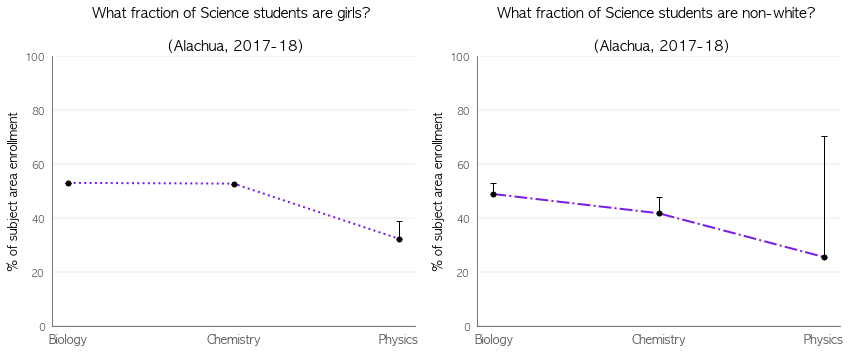

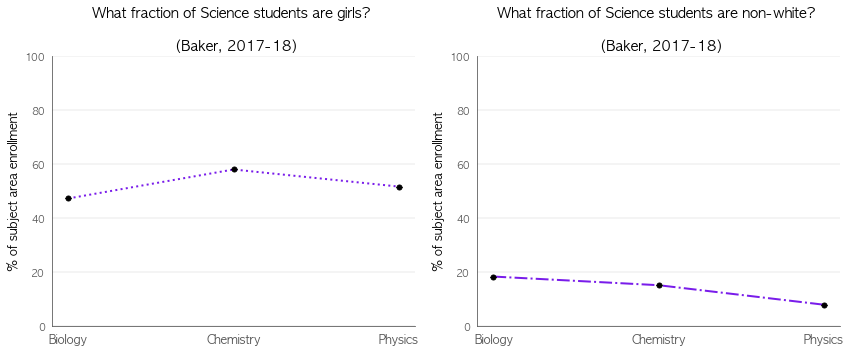

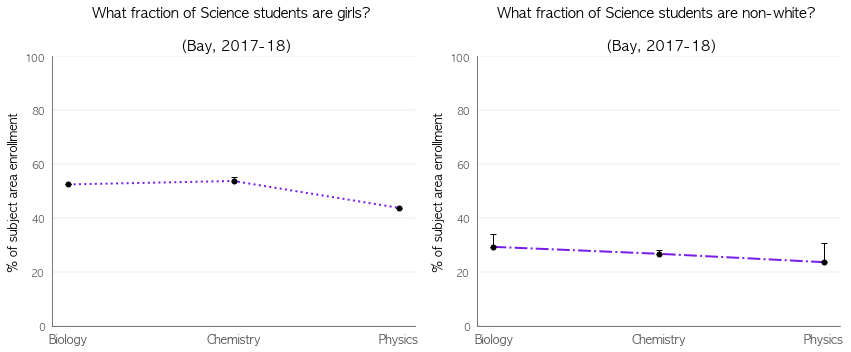

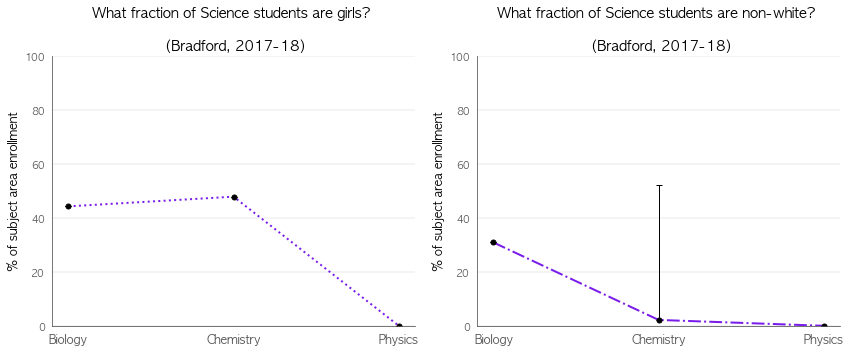

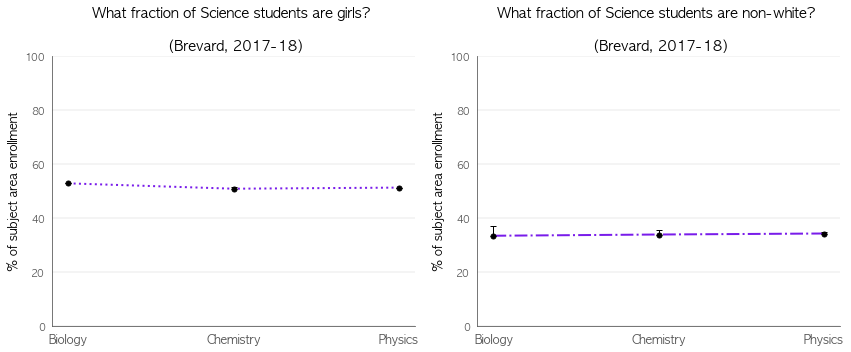

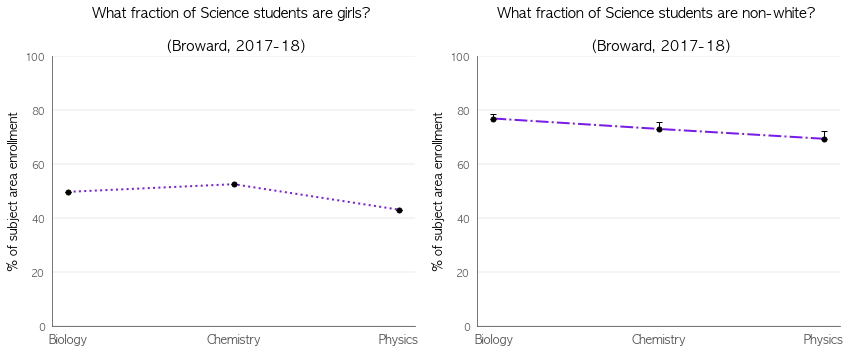

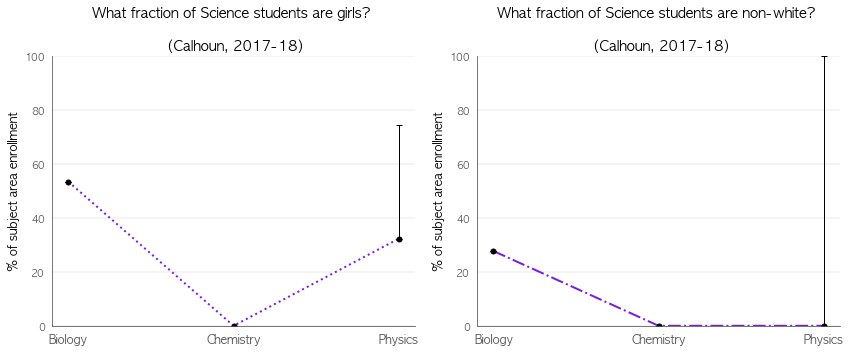

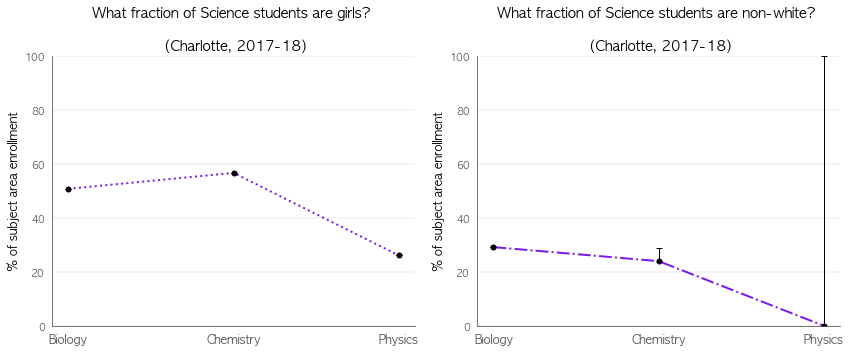

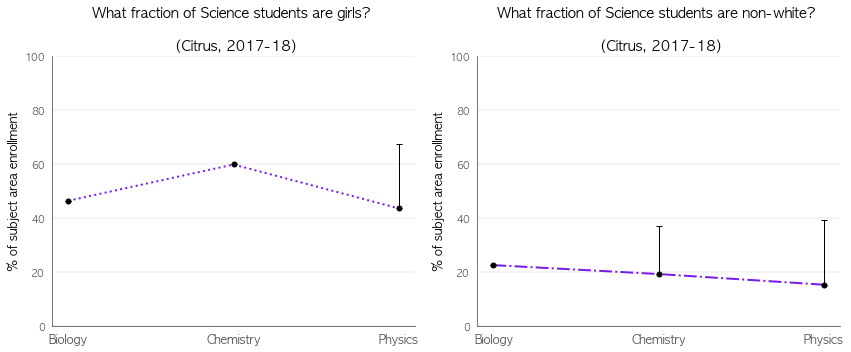

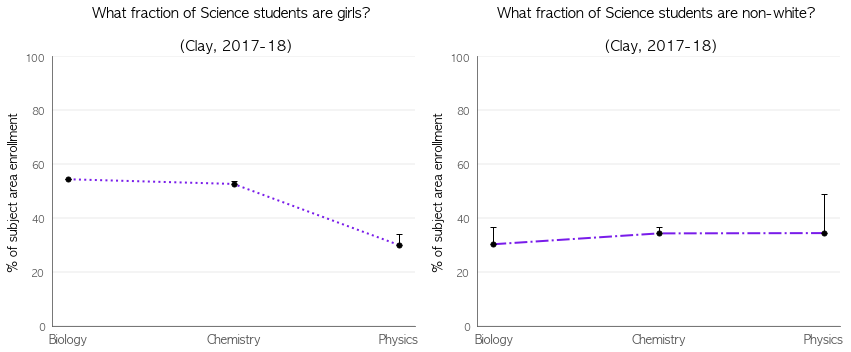

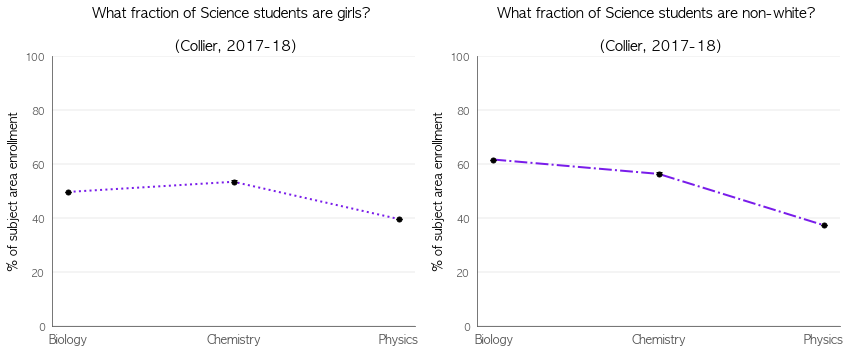

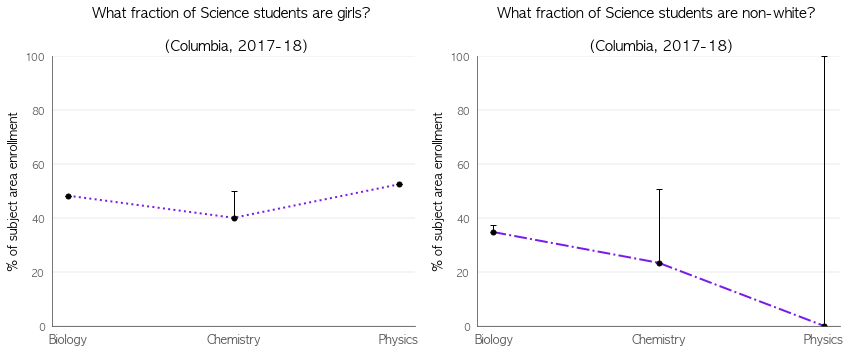

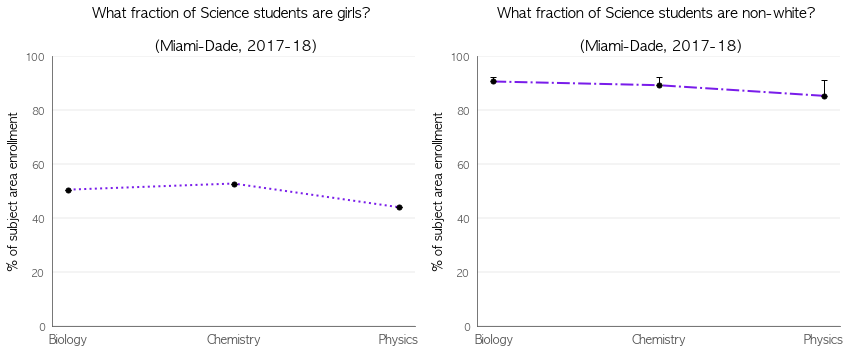

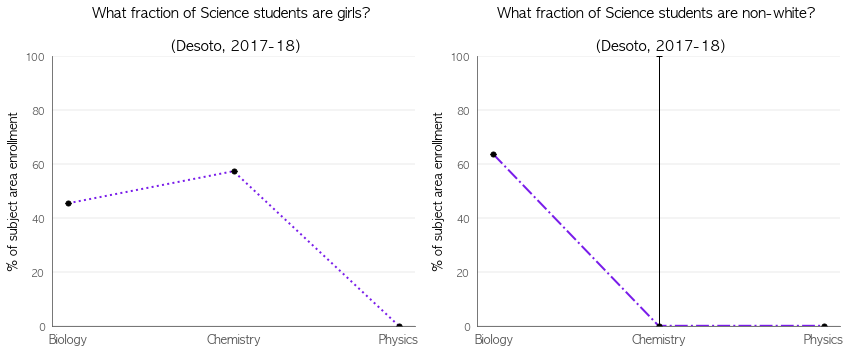

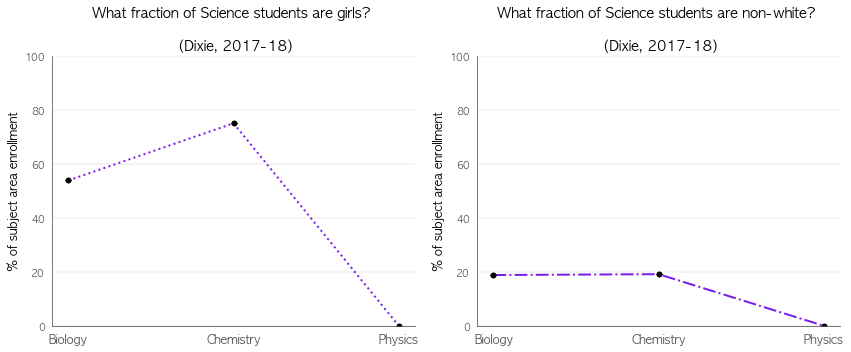

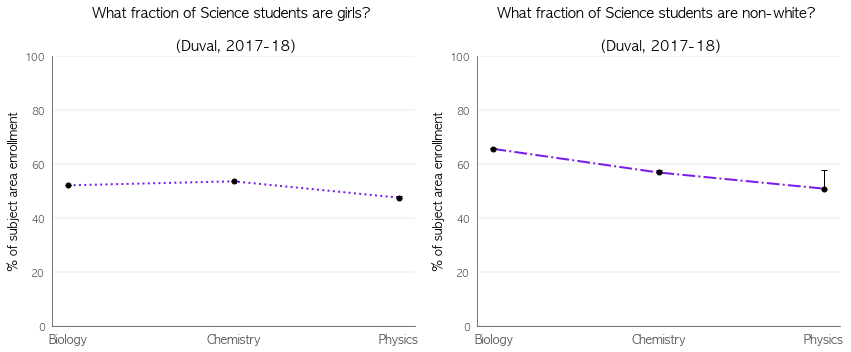

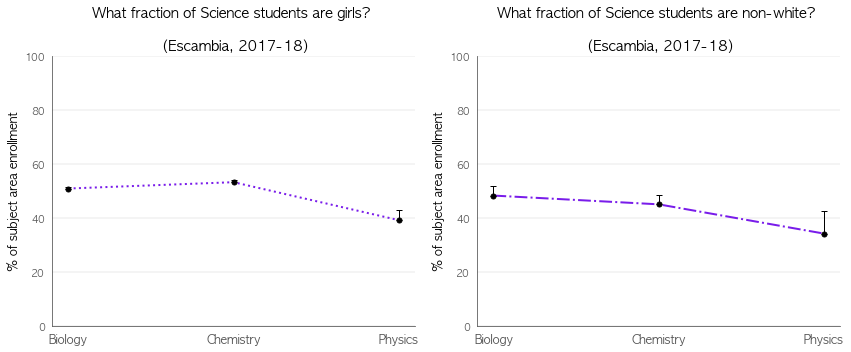

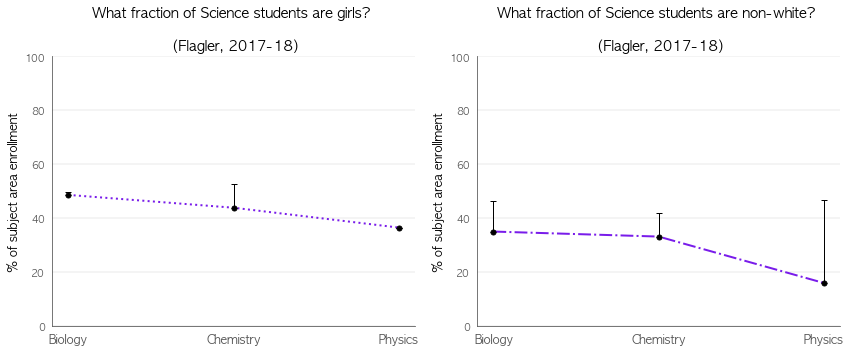

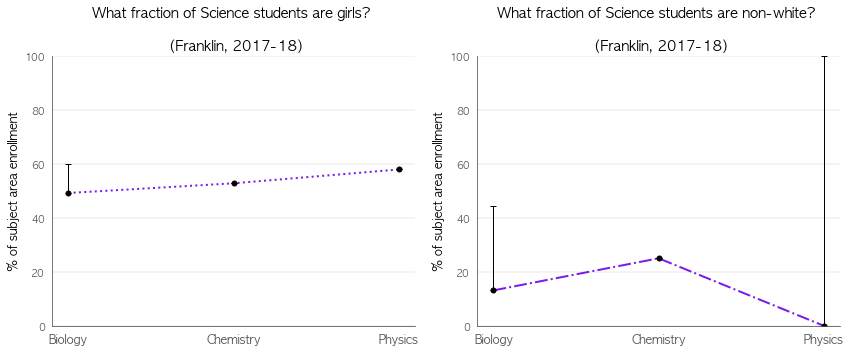

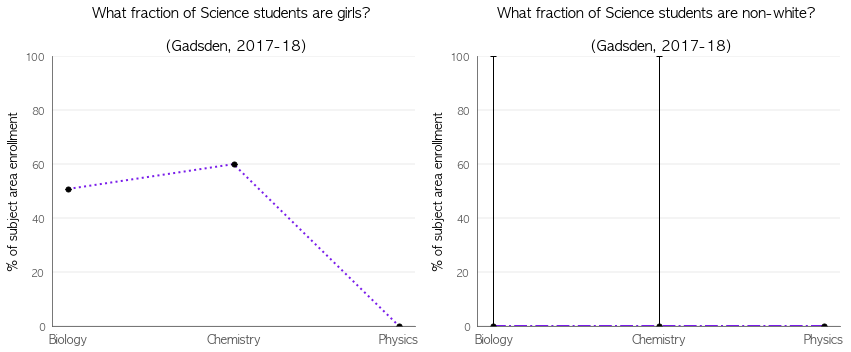

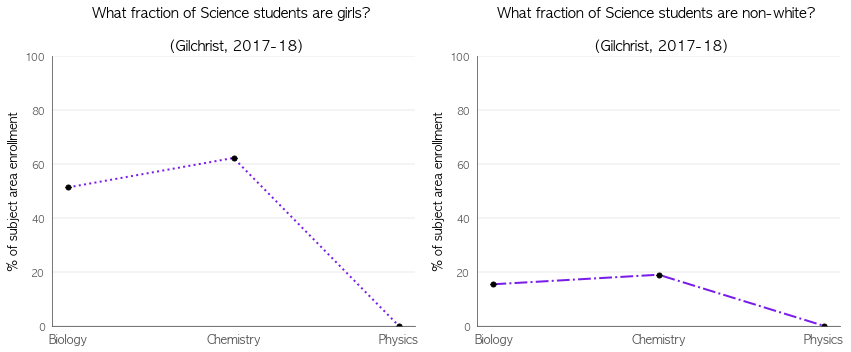

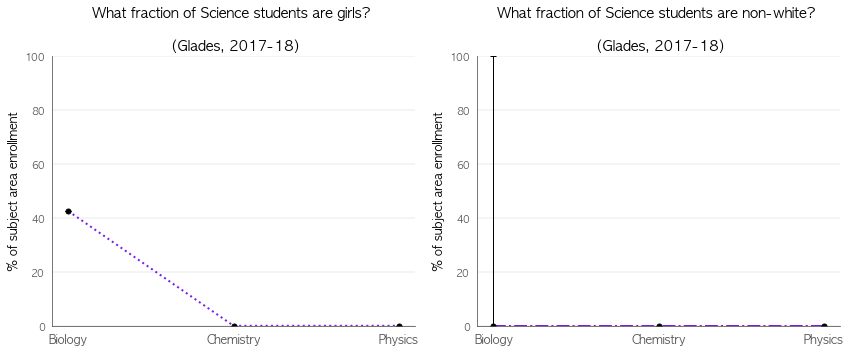

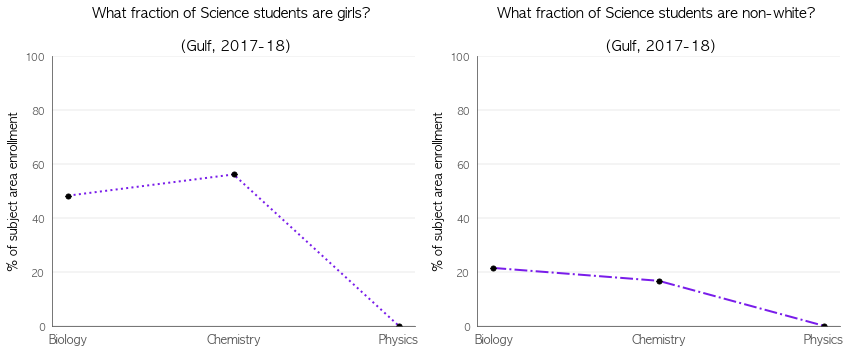

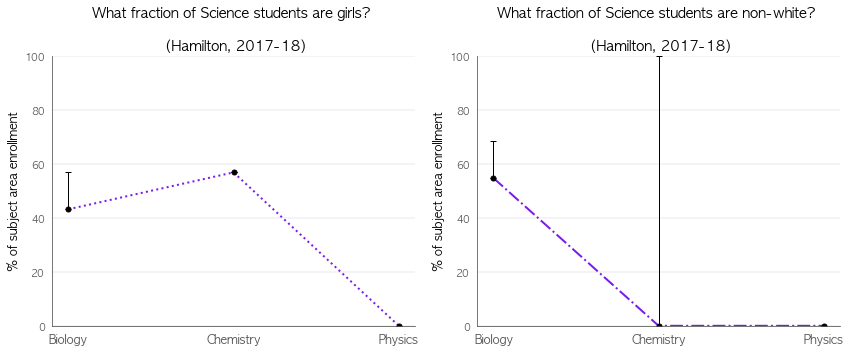

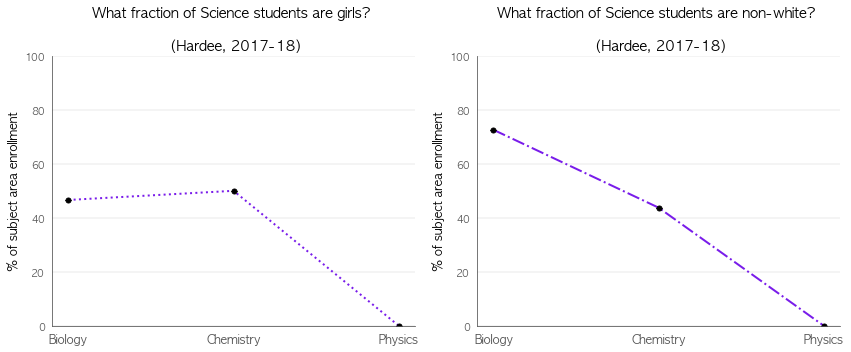

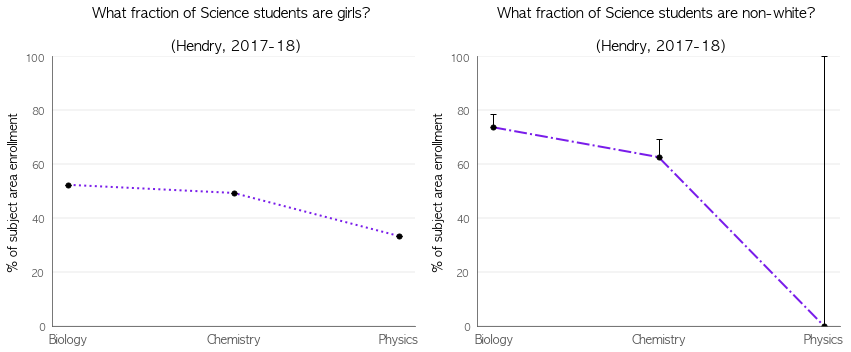

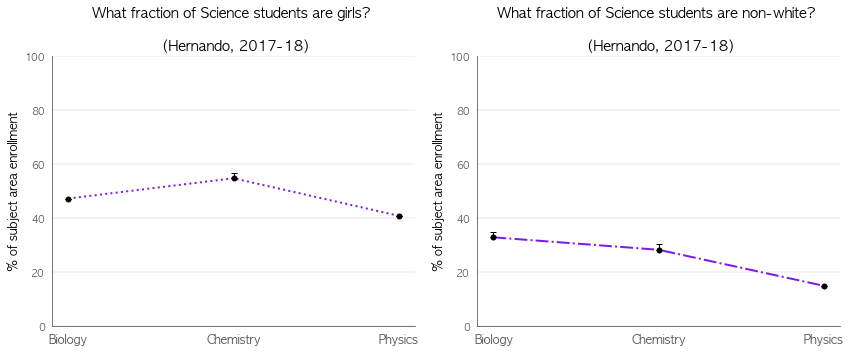

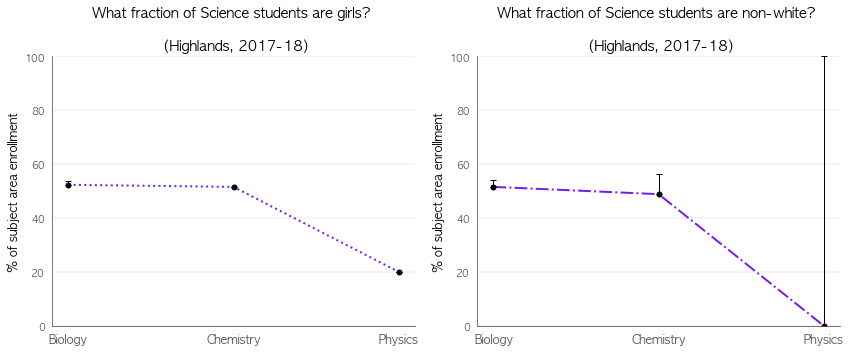

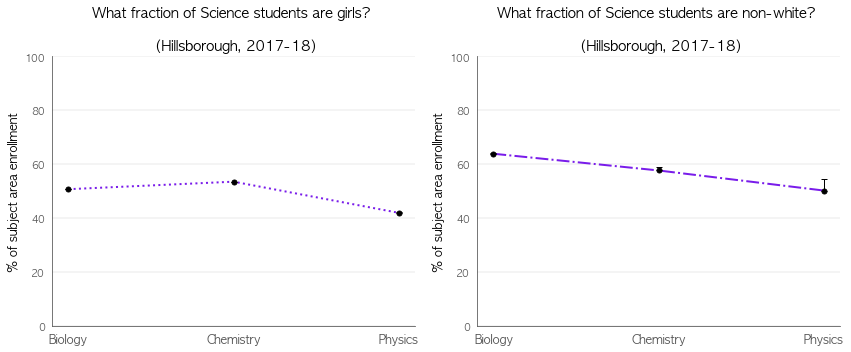

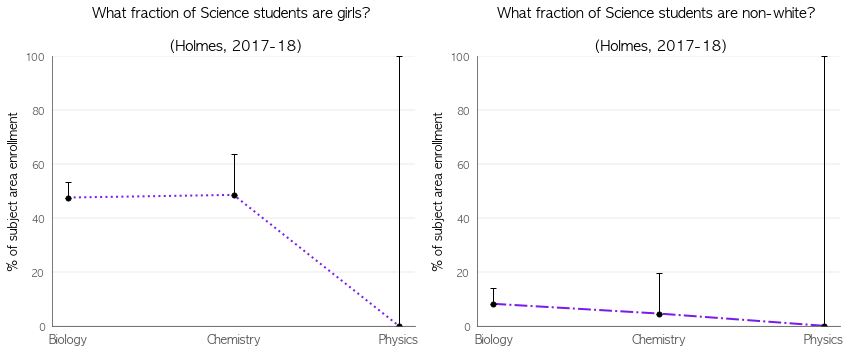

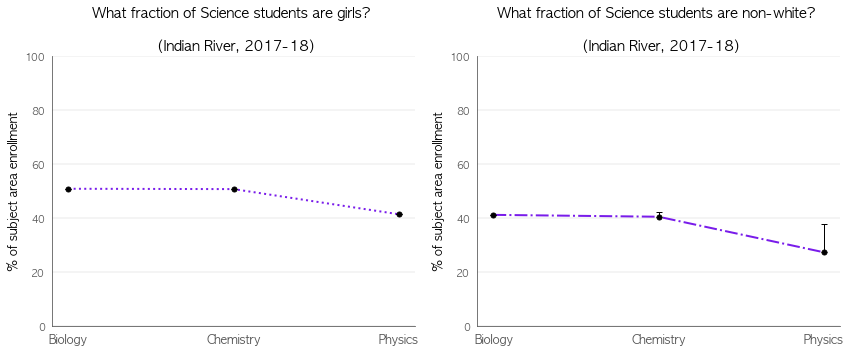

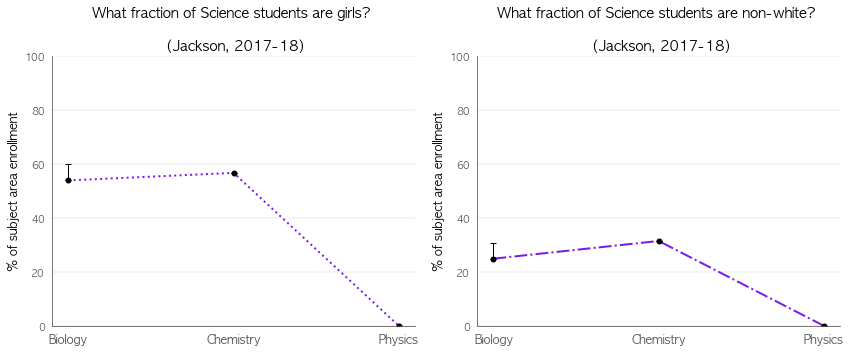

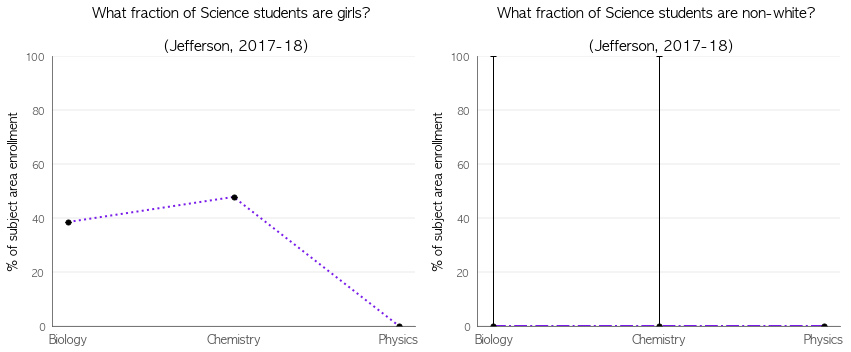

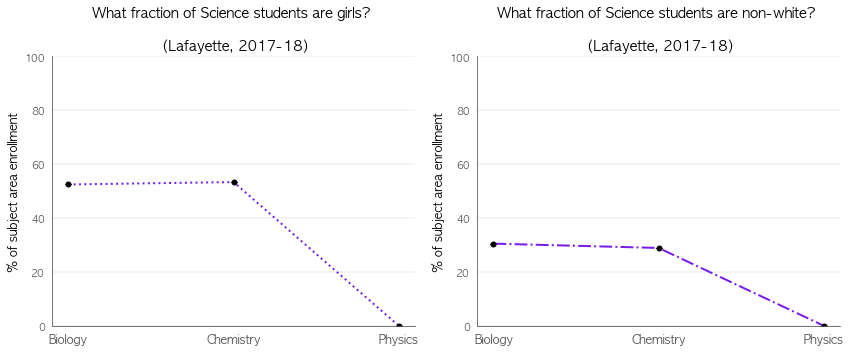

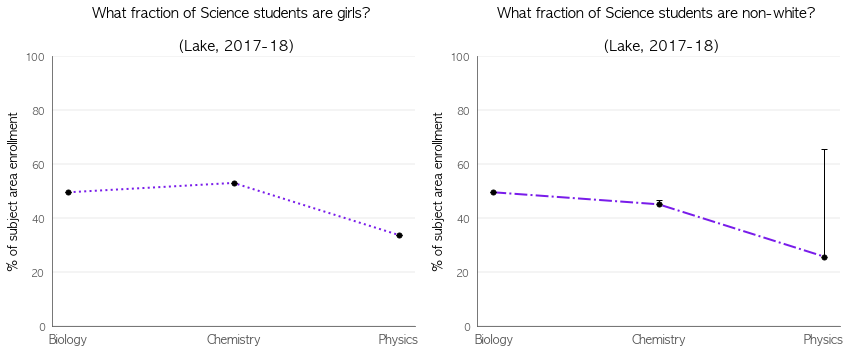

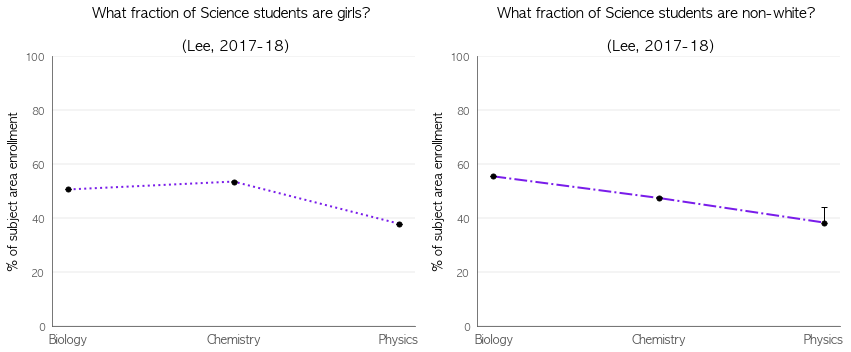

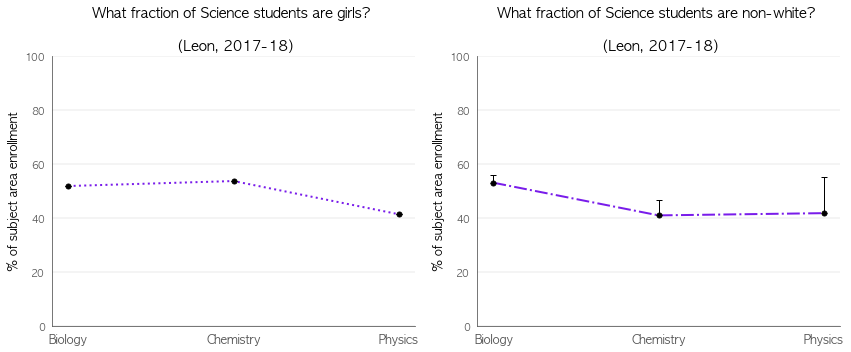

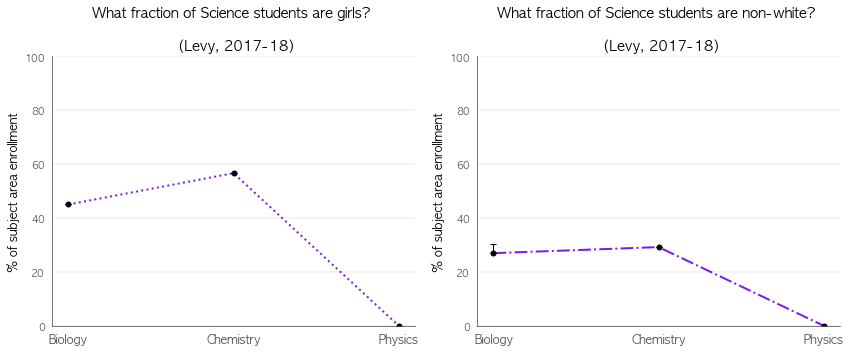

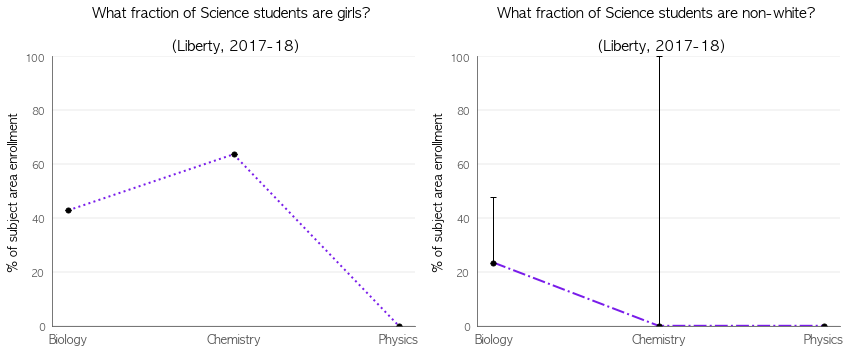

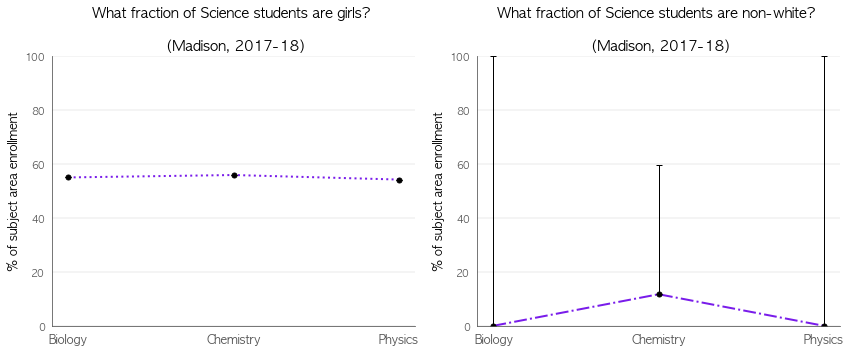

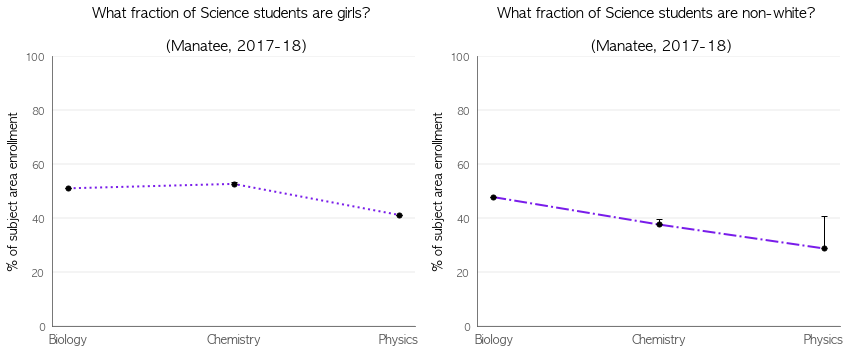

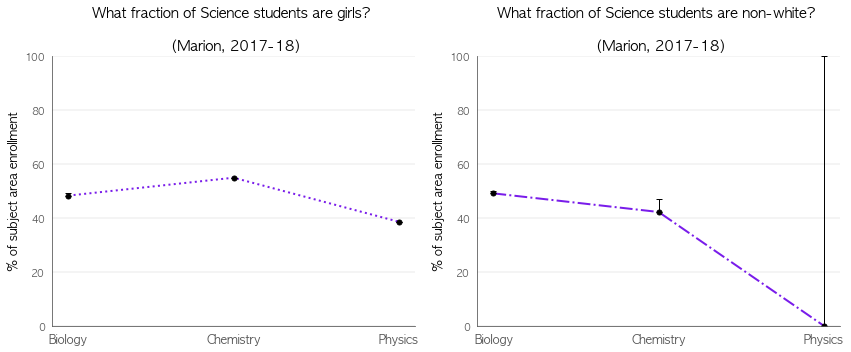

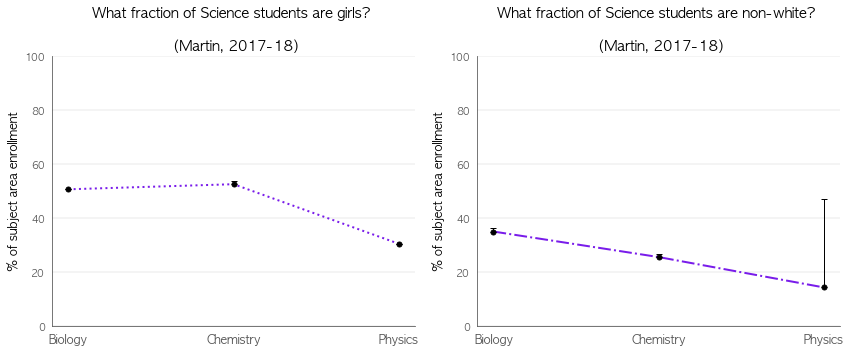

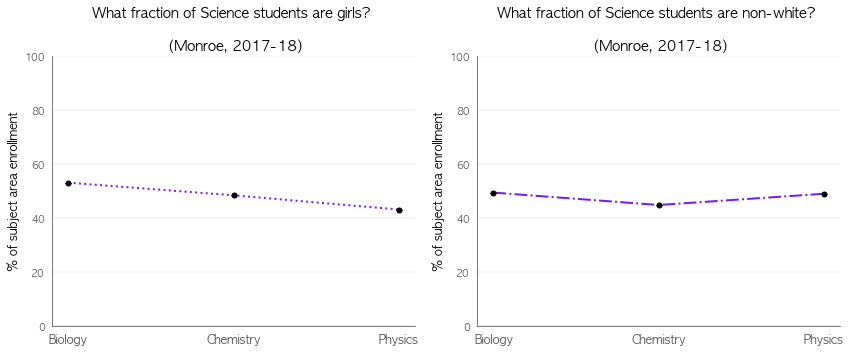

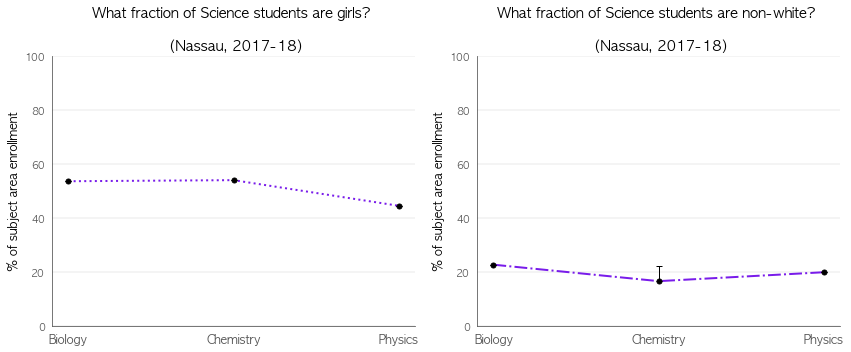

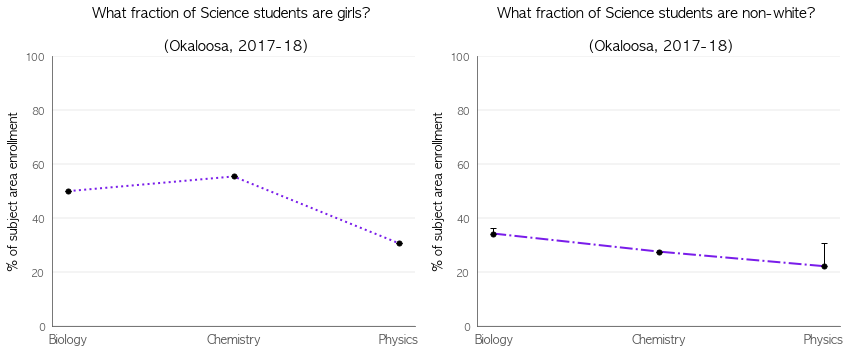

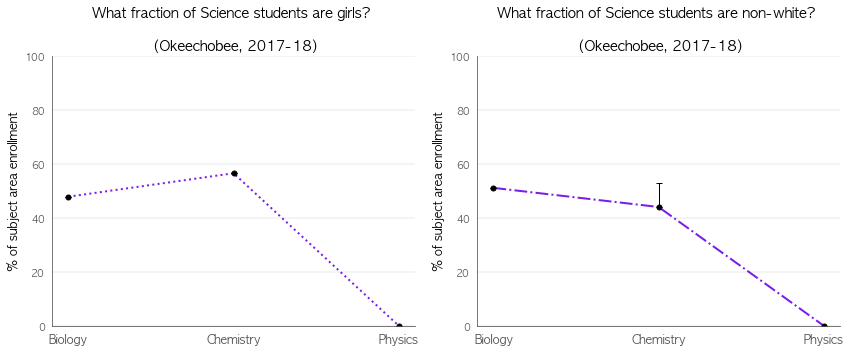

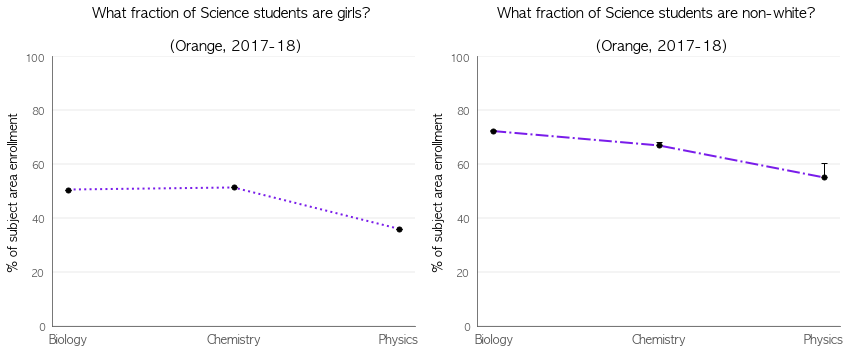

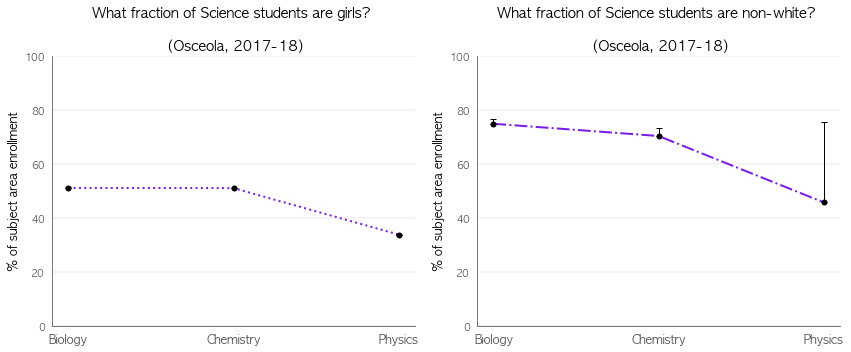

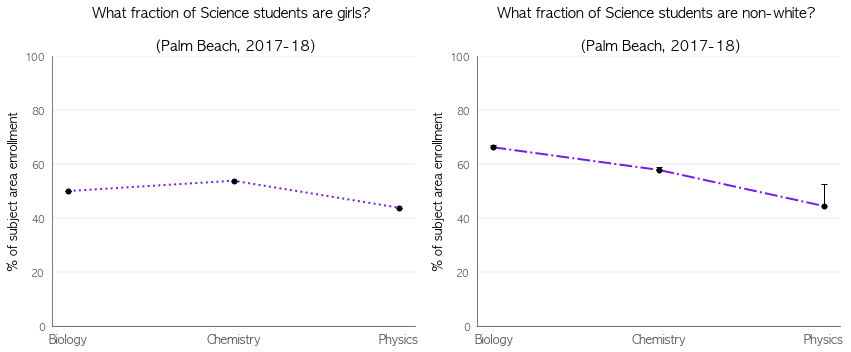

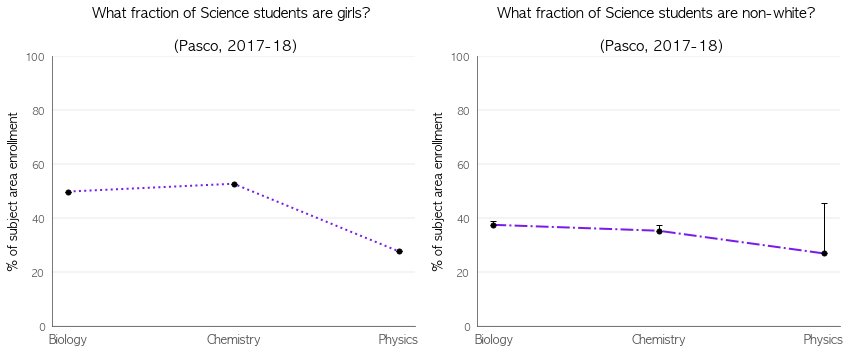

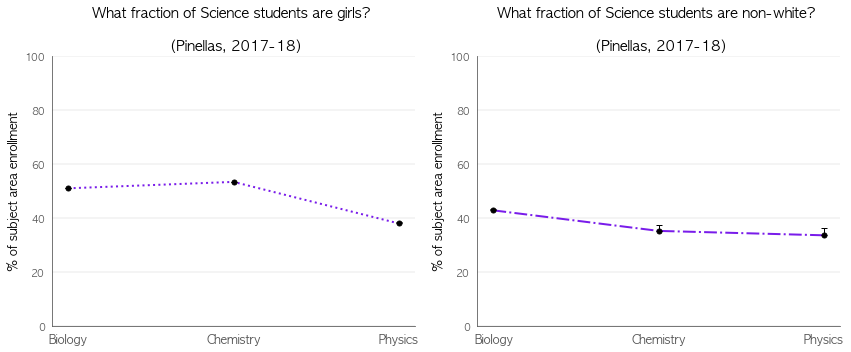

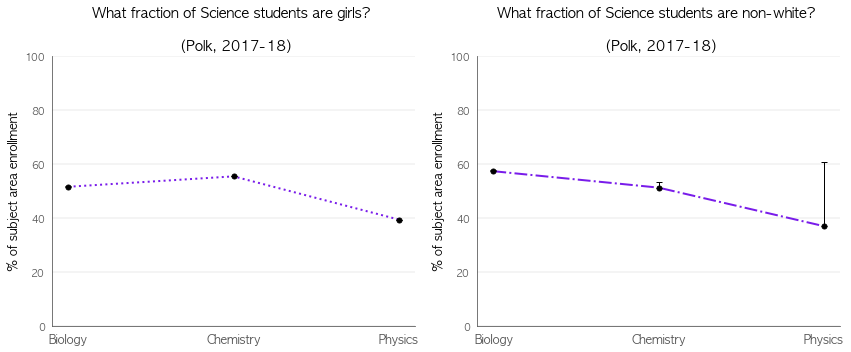

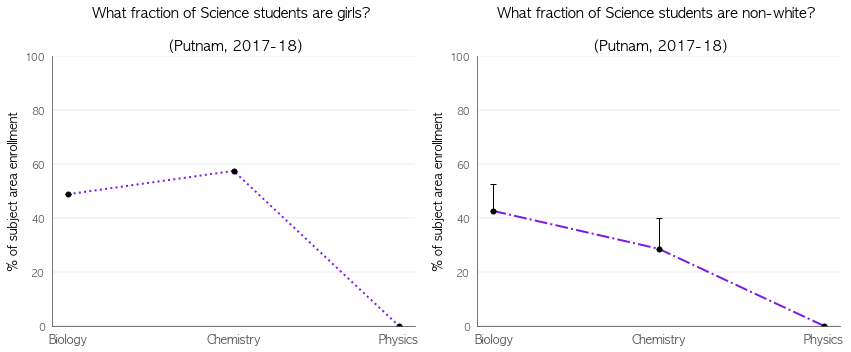

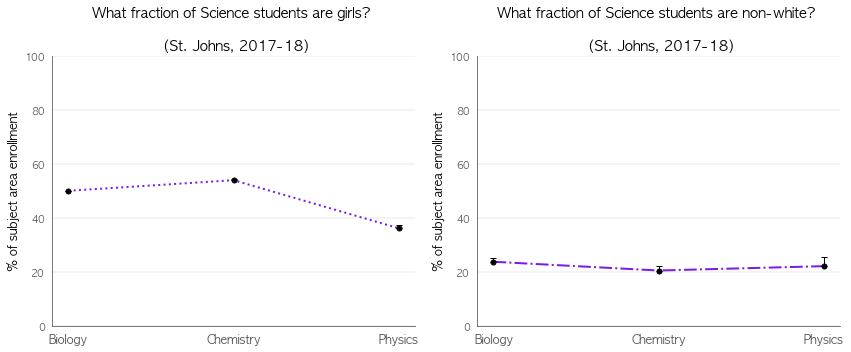

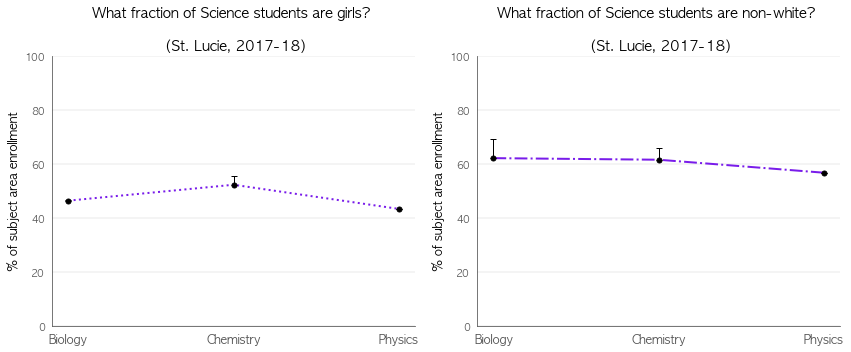

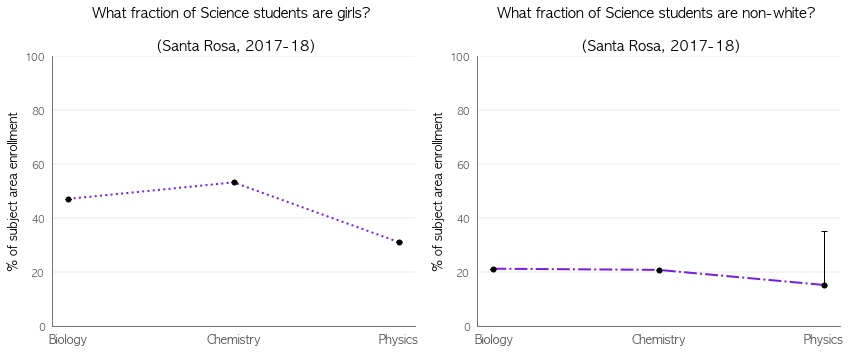

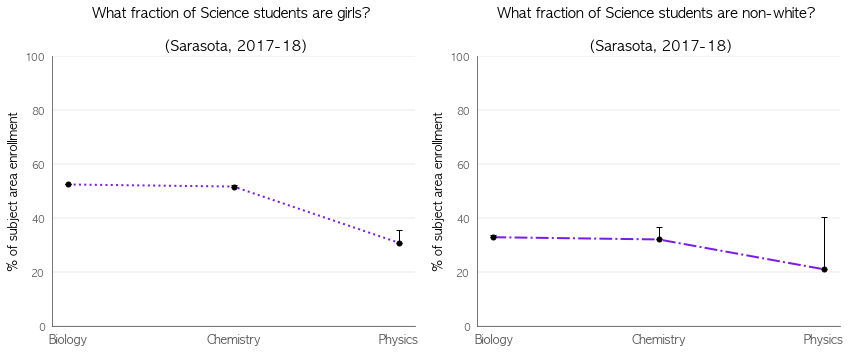

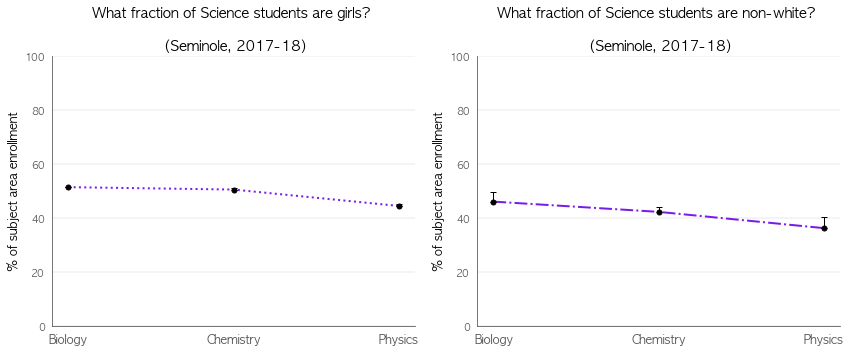

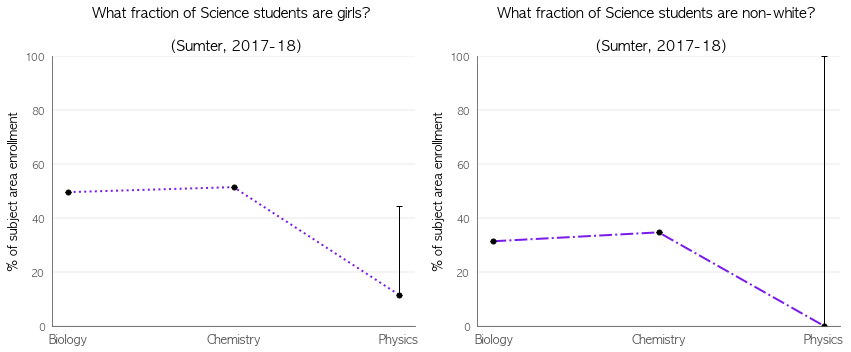

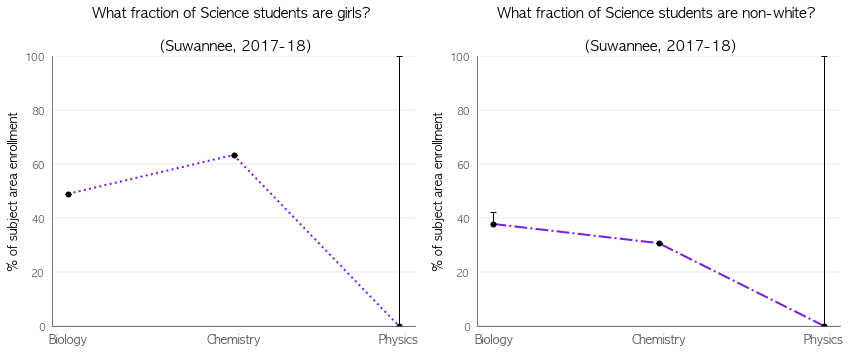

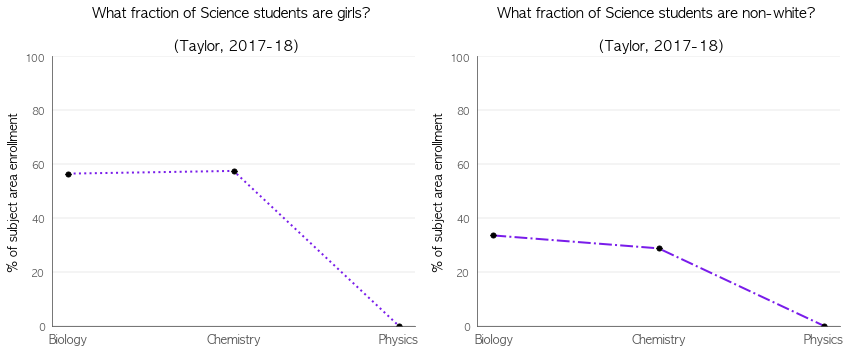

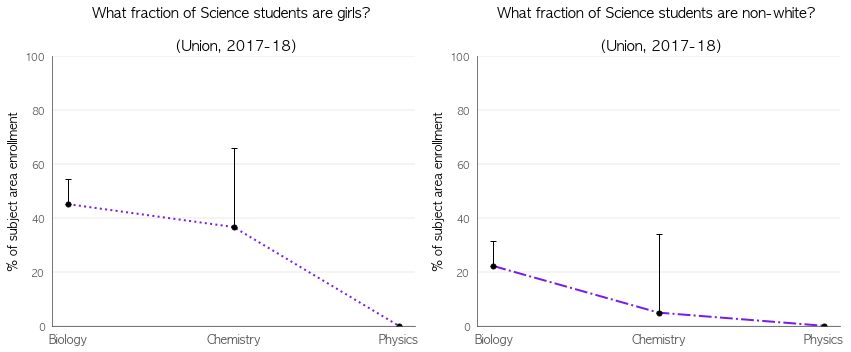

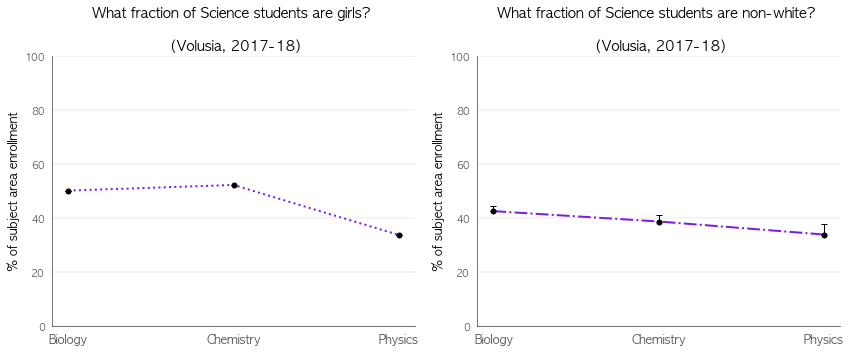

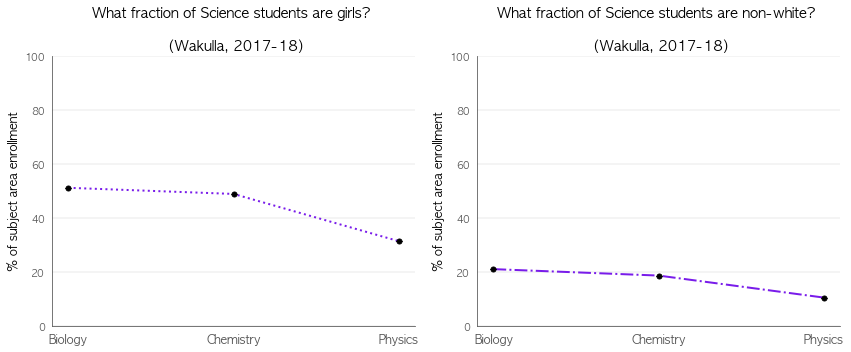

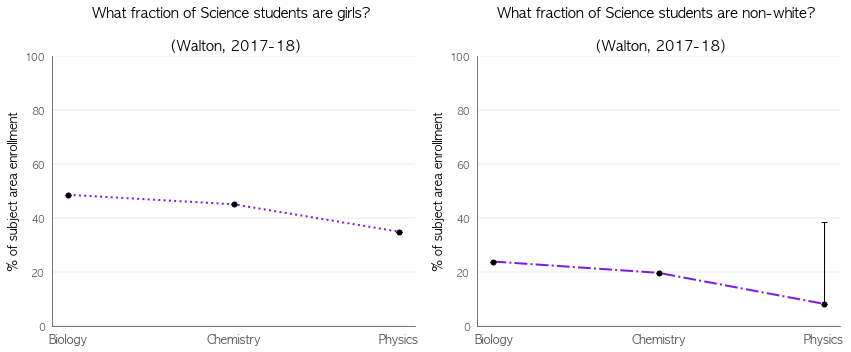

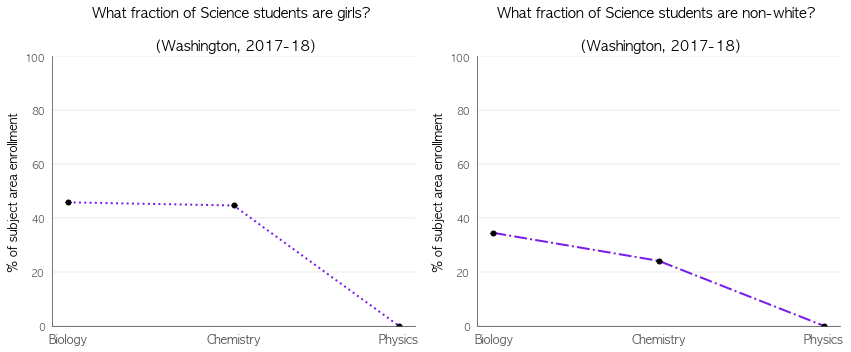

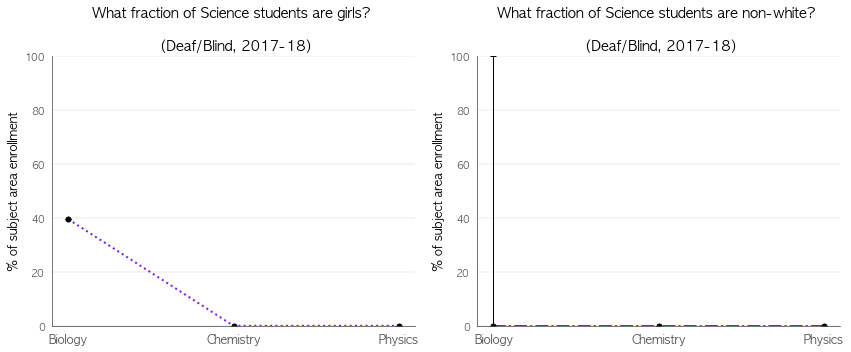

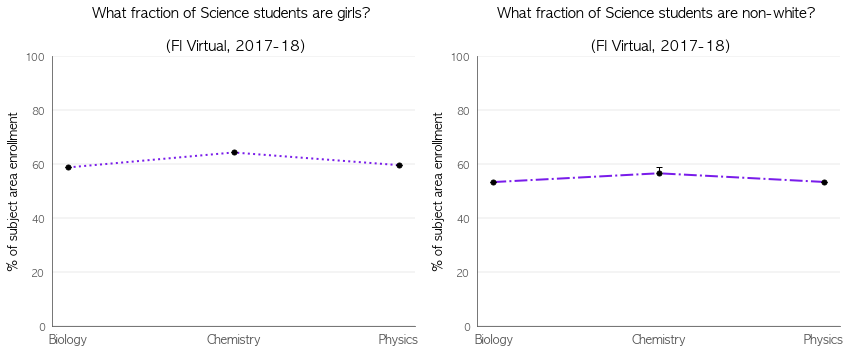

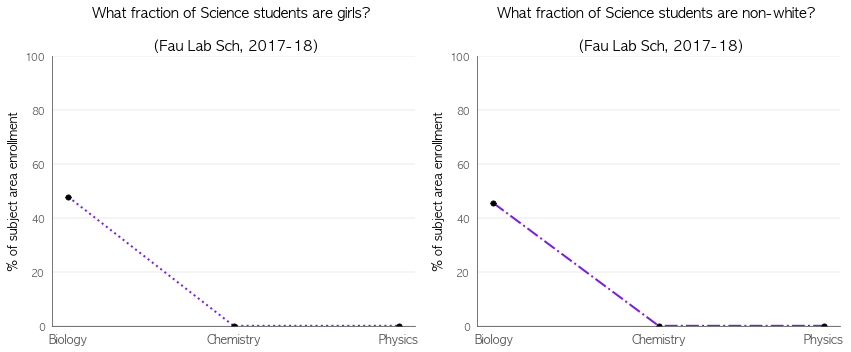

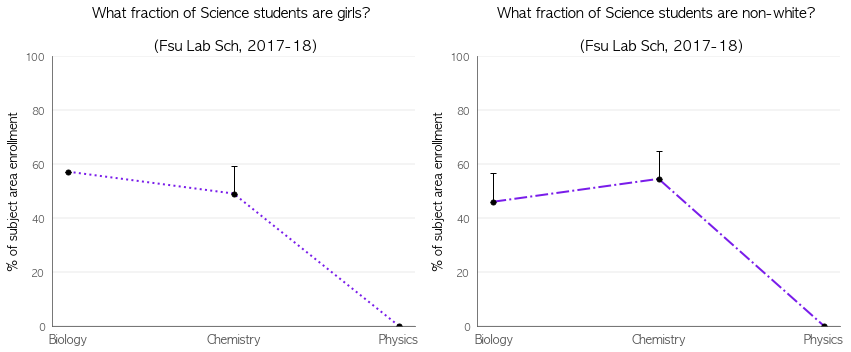

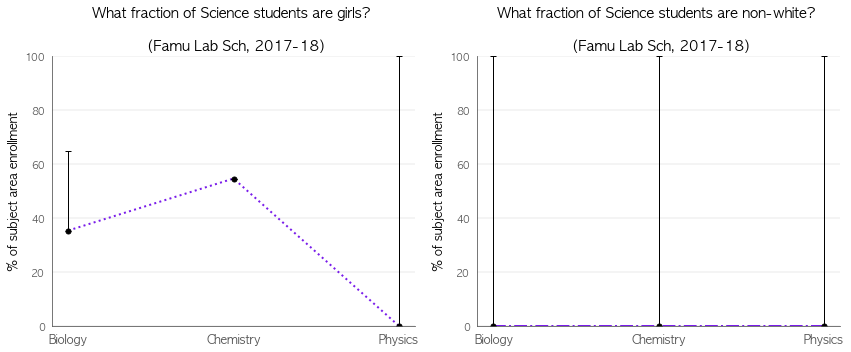

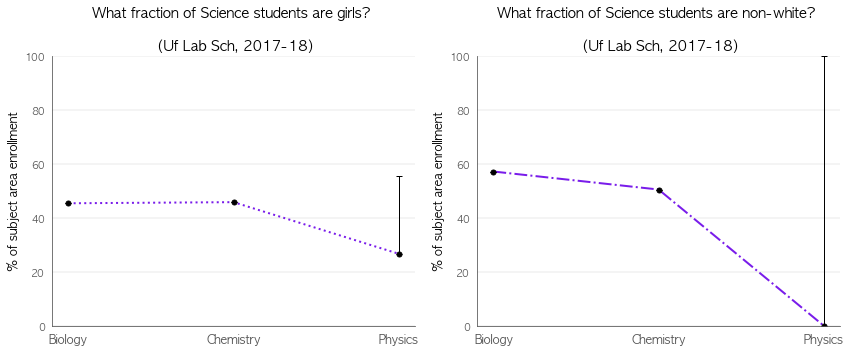

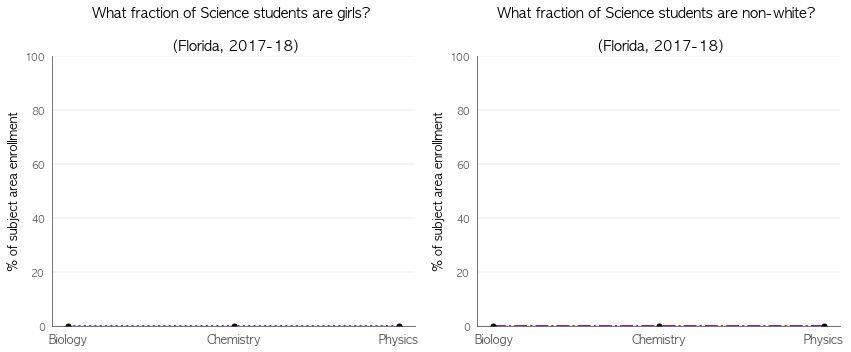

In [6]:
#############################
## both plots in one image ##

for i in district_data.district_name:
    dist = i
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))
    xticks = ['Biology','Chemistry','Physics']
    
    ###########
    ## girls ##
    plotdata_F = 100 * all_data.loc[all_data['district_name'] == dist,['bio_girls_frac','chem_girls_frac','phy_girls_frac']]
    plotdata_F_unc = 100 *all_data.loc[all_data['district_name'] == dist,['bio_girls_unc','chem_girls_unc','phy_girls_unc']]
    x = [0,1,2]

    ax1.plot(xticks,plotdata_F.T, linestyle=':', marker='o', markersize=5, \
            linewidth=2, color='#791cea', label='girls', markerfacecolor='k', markeredgecolor='k')

    ax1.errorbar(x,plotdata_F.iloc[0,:], yerr=[[0,0,0],plotdata_F_unc.iloc[0,:]], fmt='none', \
                ecolor='k', elinewidth=1, capsize=3, label='_nolegend_')

    title1= "What fraction of Science students are girls? \n\n (" + dist.title() + ", 2017-18)"
    ax1.set_title(title1, fontsize=14)
    ax1.tick_params(labelcolor='#565656')
    ax1.tick_params(axis='x', which='major', labelsize=12)
    ax1.xaxis.set_ticks_position('none')
    ax1.yaxis.set_ticks_position('none')
    ax1.set_ylim(bottom=0, top=100)
    ax1.set_ylabel('% of subject area enrollment', fontsize=12)
    ax1.spines['bottom'].set_color('#565656')
    ax1.spines['left'].set_color('#565656')
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.grid(color='#565656', axis='y', linestyle='-', linewidth=0.25, alpha=0.5)
    
    ###############
    ## non-white ##
    plotdata_NW = 100 * all_data.loc[all_data['district_name'] == dist,['bio_NW_frac','chem_NW_frac','phy_NW_frac']]
    plotdata_NW_unc = 100 * all_data.loc[all_data['district_name'] == dist,['bio_NW_unc','chem_NW_unc','phy_NW_unc']]

    ax2.plot(xticks,plotdata_NW.T, linestyle='-.', marker='o', markersize=5, \
            linewidth=2, color='#791cea', label='non-white', markerfacecolor='k', markeredgecolor='k')

    ax2.errorbar(x,plotdata_NW.iloc[0,:], yerr=[[0,0,0],plotdata_NW_unc.iloc[0,:]], fmt='none', \
                ecolor='k', elinewidth=1, capsize=3, label='_nolegend_')

    title2= "What fraction of Science students are non-white? \n\n (" + dist.title() + ", 2017-18)"
    ax2.set_title(title2, fontsize=14)
    ax2.tick_params(labelcolor='#565656')
    ax2.tick_params(axis='x', which='major', labelsize=12)
    ax2.xaxis.set_ticks_position('none')
    ax2.yaxis.set_ticks_position('none')
    ax2.set_ylim(bottom=0, top=100)
    ax2.set_ylabel('% of subject area enrollment', fontsize=12)
    ax2.spines['bottom'].set_color('#565656')
    ax2.spines['left'].set_color('#565656')
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.grid(color='#565656', axis='y', linestyle='-', linewidth=0.25, alpha=0.5)
    plt.tight_layout()
    dist = dist.replace("/","").replace(" ","_").replace(".","")
    fig.savefig("../plots/District_plots/" + dist + "_2demog.png", bbox_inches="tight", dpi = 300)
    plt.show()
    plt.close(fig)

## Overview of District-level Data
TBA
- list column headings, explanations
- plots to preview distributions for each column

In [ ]:
plt.figure(figsize=(8,2))
plt.title("District-Level Data - Counts")
sns.boxplot(data=district_data.iloc[:-7,2:5], orient="h");

In [ ]:
plt.figure(figsize=(8,7))
plt.title("District-Level Data - Percents")
sns.boxplot(data=district_data.iloc[:-7,5:], orient="h");

## Overview of Course-level Data
TBA
- list column headings, explanations
- plots to preview distributions for each column 

In [ ]:
plt.figure(figsize=(8,10))
plt.title("Course-Level Data - Total Counts")
sns.boxplot(data=course_data.iloc[:-7,3:22], orient="h");

In [ ]:
plt.figure(figsize=(8,2))
plt.title("Course-Level Data - Percents")
sns.boxplot(data=course_data.iloc[:-7,22:24], orient="h");

# Dist and KDE plots

In [ ]:
# some courses have < 10 girls, showing as 0
girl_data = course_data.query('Total_F != 0 and course_number == @biology')
plt.figure(figsize=(8,1))
plt.xlim(0, 1)
plt.title("Percent Enrollment of Girls in Biology Courses")
sns.boxplot(data=girl_data.iloc[:,-2:-1], orient="h");

In [ ]:
girl_data = course_data.query('Total_F != 0 and course_number == @chemistry')
plt.figure(figsize=(8,1))
plt.xlim(0, 1)
plt.title("Percent Enrollment of Girls in Chemistry Courses")
sns.boxplot(data=girl_data.iloc[:,-2:-1], orient="h");

In [ ]:
girl_data = course_data.query('Total_F != 0 and course_number == @physics')
plt.figure(figsize=(8,1))
plt.xlim(0, 1)
plt.title("Percent Enrollment of Girls in Physics Courses")
sns.boxplot(data=girl_data.iloc[:,-2:-1], orient="h");

In [ ]:
plt.figure(figsize=(8,1))
plt.hist(girl_data.loc[:,'frac_girls'], normed=1);

In [ ]:
bio_girls = course_data.query('Total_F != 0 and course_number == @biology').frac_girls
chem_girls = course_data.query('Total_F != 0 and course_number == @chemistry').frac_girls
phys_girls = course_data.query('Total_F != 0 and course_number == @physics').frac_girls

plt.figure(figsize=(10,3))
title = "Gender Disparity in FL Science Enrollment"
ax = sns.kdeplot(bio_girls, shade=True, color='#55AD89', label='Biology')
sns.kdeplot(chem_girls, shade=True, color='#6388B4', label='Chemistry')
sns.kdeplot(phys_girls, shade=True, color='#FFAE34', label='Physics')

#ax.title('Gender Disparity in FL Science Enrollment')
ax.tick_params(axis='y', labelleft=False)
ax.set_xlabel('fraction of girls enrolled')
#ax.set_ylabel('courses across all districts')
ax.yaxis.set_ticks_position('none')
#ax.yaxis.label.set_visible(False)
ax.spines['bottom'].set_color('#565656')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.grid(color='#565656', axis='x', linestyle='-', linewidth=0.25, alpha=0.5)
ax.legend(ncol=1, fancybox=True, loc='upper right')

fig = ax.get_figure()
#fig.savefig("./plots/FL_gender_dist.png", bbox_inches="tight", dpi = 300)
plt.show()
plt.close(fig)

In [ ]:
bio_girls = course_data.query('Total_F != 0 and course_number == @biology and course_name == "BIO 1"').frac_girls
bio_girlsH = course_data.query('Total_F != 0 and course_number == @biology and course_name != "BIO 1"').frac_girls
chem_girls = course_data.query('Total_F != 0 and course_number == @chemistry and course_name == "CHEM 1"').frac_girls
chem_girlsH = course_data.query('Total_F != 0 and course_number == @chemistry and course_name != "CHEM 1"').frac_girls
phys_girls = course_data.query('Total_F != 0 and course_number == @physics and course_name == "PHYS 1"').frac_girls
phys_girlsH = course_data.query('Total_F != 0 and course_number == @physics and course_name != "PHYS 1"').frac_girls

plt.figure(figsize=(10,3))
ax = sns.kdeplot(bio_girls, shade=True, color='#55AD89', label='Biology 1')
sns.kdeplot(chem_girls, shade=True, color='#6388B4', label='Chemistry 1')
sns.kdeplot(phys_girls, shade=True, color='#FFAE34', label='Physics 1')
sns.kdeplot(bio_girlsH, shade=False, color='#55AD89', label='Biology-adv')
sns.kdeplot(chem_girlsH, shade=False, color='#6388B4', label='Chemistry-adv')
sns.kdeplot(phys_girlsH, shade=False, color='#FFAE34', label='Physics-adv')

ax.tick_params(axis='y', labelleft=False)
ax.set_xlabel('fraction of girls enrolled')
ax.yaxis.set_ticks_position('none')
ax.spines['bottom'].set_color('#565656')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.grid(color='#565656', axis='x', linestyle='-', linewidth=0.25, alpha=0.5)
ax.legend(ncol=2, fancybox=True, loc='upper right')

fig = ax.get_figure()
#fig.savefig("../plots/FL_gender_dist2.png", bbox_inches="tight", dpi = 300)
plt.show()
plt.close(fig)

In [ ]:
bio_NW = course_data.query('Total_enrolled != 0 and course_number == @biology').frac_nonwhite
chem_NW = course_data.query('Total_enrolled != 0 and course_number == @chemistry').frac_nonwhite
phys_NW = course_data.query('Total_enrolled != 0 and course_number == @physics').frac_nonwhite

plt.figure(figsize=(10,3))
title = "Racial Disparity in FL Science Enrollment"
ax = sns.kdeplot(bio_NW, shade=True, color='#55AD89', label='Biology')
sns.kdeplot(chem_NW, shade=True, color='#6388B4', label='Chemistry')
sns.kdeplot(phys_NW, shade=True, color='#FFAE34', label='Physics')

#ax.title('Gender Disparity in FL Science Enrollment')
ax.tick_params(axis='y', labelleft=False)
ax.set_xlabel('fraction of non-white students enrolled')
#ax.set_ylabel('courses across all districts')
ax.yaxis.set_ticks_position('none')
#ax.yaxis.label.set_visible(False)
ax.spines['bottom'].set_color('#565656')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.grid(color='#565656', axis='x', linestyle='-', linewidth=0.25, alpha=0.5)
ax.legend(ncol=1, fancybox=True, loc='upper right')

fig = ax.get_figure()
#fig.savefig("./plots/FL_racial_dist.png", bbox_inches="tight", dpi = 300)
plt.show()
plt.close(fig)

In [ ]:
bio_NW = course_data.query('Total_enrolled != 0 and course_number == @biology and course_name == "BIO 1"').frac_nonwhite
bio_NWH = course_data.query('Total_enrolled != 0 and course_number == @biology and course_name != "BIO 1"').frac_nonwhite
chem_NW = course_data.query('Total_enrolled != 0 and course_number == @chemistry and course_name == "CHEM 1"').frac_nonwhite
chem_NWH = course_data.query('Total_enrolled != 0 and course_number == @chemistry and course_name != "CHEM 1"').frac_nonwhite
phys_NW = course_data.query('Total_enrolled != 0 and course_number == @physics and course_name == "PHYS 1"').frac_nonwhite
phys_NWH = course_data.query('Total_enrolled != 0 and course_number == @physics and course_name != "PHYS 1"').frac_nonwhite

plt.figure(figsize=(10,3))
ax = sns.kdeplot(bio_NW, shade=True, color='#55AD89', label='Biology 1')
sns.kdeplot(chem_NW, shade=True, color='#6388B4', label='Chemistry 1')
sns.kdeplot(phys_NW, shade=True, color='#FFAE34', label='Physics 1')
sns.kdeplot(bio_NWH, shade=False, color='#55AD89', label='Biology-adv')
sns.kdeplot(chem_NWH, shade=False, color='#6388B4', label='Chemistry-adv')
sns.kdeplot(phys_NWH, shade=False, color='#FFAE34', label='Physics-adv')

ax.tick_params(axis='y', labelleft=False)
ax.set_xlabel('fraction of non-white students enrolled')
ax.yaxis.set_ticks_position('none')
ax.spines['bottom'].set_color('#565656')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.grid(color='#565656', axis='x', linestyle='-', linewidth=0.25, alpha=0.5)
ax.legend(ncol=2, fancybox=True, loc='upper right')

fig = ax.get_figure()
#fig.savefig("../plots/FL_racial_dist2.png", bbox_inches="tight", dpi = 300)
plt.show()
plt.close(fig)

## Other analyses

In [ ]:
phy_chem = district_data.query('physics_total != 0 & chemistry_total != 0 & district_name != "FL VIRTUAL"')
phy_chem.plot(x='chemistry_total',y='physics_total', kind='scatter', grid=True)

In [ ]:
phy_chem = district_data.query('physics_total != 0 & chemistry_total != 0 & district_name != "FL VIRTUAL"')
phy_chem.plot(x='chemistry_total',y='phy_per_chem', kind='scatter', grid=True)

In [ ]:
phy_chem[['district_name','chemistry_total','physics_total','1718s2_seniors','phy_girls_frac','phy_per_chem']]\
    .sort_values(by='phy_per_chem', ascending=False)

In [ ]:
district_data.query('physics_total != 0 & district_name != "FL VIRTUAL"').plot(x='pct_enrollment',y='phy_girls_frac', kind='scatter', \
                   ylim=(0,1), grid=True, yticks=(0,.5,1))

In [ ]:
#regression = sm.formula.ols(y=district_data['phy_girls_frac'], x=district_data['pct_enrollment'])
#regression.summary

model = sm.OLS(district_data['phy_girls_frac'],district_data['pct_enrollment'])
results = model.fit()
results.summary()

In [ ]:
high_rollers = district_data.query('pct_enrollment > .2  & district_name != "FL VIRTUAL"')
high_rollers = high_rollers[['district_name','pct_enrollment','phy_girls_frac','physics_total','1718s2_seniors']].sort_values(by='pct_enrollment', ascending=False)
high_rollers

In [ ]:
high_rollers.plot(x='pct_enrollment',y='phy_girls_frac', kind='scatter', \
                   ylim=(0,1), grid=True, yticks=(0,.5,1))

In [ ]:
sns.pairplot(high_rollers)

In [ ]:
all_rollers = district_data.query('pct_enrollment > 0  & district_name != "FL VIRTUAL"')
all_rollers = all_rollers[['district_name','pct_enrollment','phy_girls_frac','physics_total','1718s2_seniors']].sort_values(by='pct_enrollment', ascending=False)
all_rollers

In [ ]:
all_rollers.plot(x='pct_enrollment',y='phy_girls_frac', kind='scatter', \
                   ylim=(0,1), grid=True, yticks=(0,.5,1))

In [ ]:
sns.pairplot(all_rollers)

In [ ]:
plotdata = district_data

In [ ]:
from pandas.plotting import scatter_matrix
scatter_matrix(plotdata.iloc[:,2:], alpha=0.2, figsize=(10, 10), diagonal='kde');

In [ ]:
phy_corr = plotdata.iloc[:,:].corr().iloc[:,-1]
phy_corr.sort_values(ascending=False)